# DA for DMD kol_model.py

In [1]:
import random
from time import perf_counter

import torch
from torch import nn
import torch.nn.functional as F
import numpy
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = True


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)


def set_device():
    """
    Use CPU if cuda device is not available
    setup tf32 for faster GPU computation
    """
    if torch.cuda.device_count() == 0:
        return "cpu"
    torch.set_float32_matmul_precision("high")
    return "cuda"


set_seed(42)
g = torch.Generator()
g.manual_seed(42)
device = set_device()
device

/scratch_dgxl/wy524/miniconda3/envs/irp-env/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


'cpu'

In [2]:
from kol_model import KOL_C_FORWARD

forward_model = KOL_C_FORWARD()
forward_model.load_state_dict(torch.load('best_kol_model_weights/forward_model.pt', weights_only=True, map_location=device))
forward_model.C_forward = torch.load('best_kol_model_weights/C_forward.pt', weights_only=True, map_location=device)
forward_model.eval()

print(forward_model)

KOL_C_FORWARD(
  (K_S): KOL_K_S(
    (patch_embed): OverlapPatchEmbed(
      (proj): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (Conv2D_size7_1): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (transformer_block1): TransformerBlock(
      (norm1): LayerNorm(
        (body): WithBias_LayerNorm()
      )
      (attn): Attention(
        (qkv): Conv2d(32, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (qkv_dwconv): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96, bias=False)
        (project_out): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (norm2): LayerNorm(
        (body): WithBias_LayerNorm()
      )
      (ffn): FeedForward(
        (project_in): Conv2d(32, 170, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (dwconv): Conv2d(170, 170, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=170, bias=False)
        (project_out): Conv2d(8

In [3]:
from Dataset import KolDynamicsDataset

foward_step = 12

val_idx = 3

kol_train_dataset = KolDynamicsDataset(data_path="../../../data/kolmogorov/kolmogorov_train_data.npy",
                seq_length = foward_step,
                mean=None,
                std=None)
    
kol_val_dataset = KolDynamicsDataset(data_path="../../../data/kolmogorov/kolmogorov_val_data.npy",
            seq_length = foward_step,
            mean=kol_train_dataset.mean,
            std=kol_train_dataset.std)

denorm = kol_val_dataset.denormalizer()

Loaded Cylinder data with shape: (96, 320, 1, 64, 64)
dataset total samples: 29568
Loaded Cylinder data with shape: (24, 320, 1, 64, 64)
dataset total samples: 7392


In [4]:
groundtruth = kol_val_dataset.data[val_idx, ...]
groundtruth = torch.from_numpy(groundtruth)

groundtruth.shape

torch.Size([320, 1, 64, 64])

In [5]:
def visualize_image(image_2d, title='Image', cmap='viridis'):
    if isinstance(image_2d, torch.Tensor):
        image_2d = image_2d.detach().cpu().numpy()

    plt.figure(figsize=(2, 2))
    plt.imshow(image_2d, cmap=cmap)
    plt.colorbar()
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
import os
import sys
import numpy as np

class SparseObservationHandler:
    
    def __init__(self, observation_ratio: float = 0.1, seed: int = 42):
        self.observation_ratio = observation_ratio
        self.seed = seed
        self.observation_mask = None
        self.observation_indices = None
        
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
    
    def generate_observation_mask(self, image_shape):
        if len(image_shape) == 4:  # (B, C, H, W)
            _, C, H, W = image_shape
        elif len(image_shape) == 3:  # (C, H, W)
            C, H, W = image_shape
        else:
            raise ValueError(f"Unsupported image shape: {image_shape}")
        
        total_pixels = C * H * W
        num_observations = int(total_pixels * self.observation_ratio)
        
        observation_indices = torch.randperm(total_pixels)[:num_observations]
        
        mask = torch.zeros(total_pixels, dtype=torch.bool)
        mask[observation_indices] = True
        
        self.observation_mask = mask
        self.observation_indices = observation_indices
        
        return mask, observation_indices
    
    def apply_sparse_observation(self, full_image, mask=None):
        if mask is None:
            mask = self.observation_mask
        
        flat_image = full_image.flatten()
        observed_values = flat_image[mask]
        
        return observed_values

### DA

In [7]:
import torchda

In [8]:
# del cyl_train_dataset
# del cyl_val_dataset

In [9]:
observation_ratio = 0.2
obs_handler = SparseObservationHandler(observation_ratio=observation_ratio, seed=42)

In [ ]:
start_da_end_idxs = (40, 45, 65)

time_obs = [
    start_da_end_idxs[1],
    start_da_end_idxs[1] + 10,
]
gaps = [10] * (len(time_obs) - 1)

full_y_data = [
    kol_val_dataset.normalize(groundtruth[i+1, ...])
    for i in range(groundtruth.shape[0])
    if i in time_obs
]

full_y_data = torch.cat(full_y_data).to(device)

In [11]:
print(full_y_data.shape)

torch.Size([2, 1, 64, 64])


In [12]:
sample_image_shape = full_y_data[0].shape  # (C, H, W)
mask, indices = obs_handler.generate_observation_mask(sample_image_shape)
mask = mask.to(device)

sparse_y_data = []
for full_img in full_y_data:
    sparse_obs = obs_handler.apply_sparse_observation(full_img, mask)
    sparse_y_data.append(sparse_obs)
sparse_y_data = torch.stack(sparse_y_data)

print(f"Original observation shape: {full_y_data.shape}")
print(f"Sparse observation shape: {sparse_y_data.shape}")
print(f"Observation ratio: {sparse_y_data.shape[1] / full_y_data[0].numel():.3f}")

Original observation shape: torch.Size([2, 1, 64, 64])
Sparse observation shape: torch.Size([2, 819])
Observation ratio: 0.200


In [13]:
def H_sparse(x):
    x_reconstructed = forward_model.K_S_preimage(x)
    sparse_obs = obs_handler.apply_sparse_observation(x_reconstructed.squeeze(), mask)
    return sparse_obs.unsqueeze(0)

In [14]:
latent_dim = forward_model.C_forward.shape[0]
B = torch.eye(latent_dim, device=device)

obs_dim = sparse_y_data.shape[1]
R = 1e-3 * torch.eye(obs_dim, device=device)

print(f"Background covariance B shape: {B.shape}")
print(f"Observation covariance R shape: {R.shape}")

Background covariance B shape: torch.Size([512, 512])
Observation covariance R shape: torch.Size([819, 819])


In [15]:
def dmd_warpper(z_t, time_fw=None, *args):
    if time_fw == None:
        if z_t.ndim == 1:
            z_t = z_t.unsqueeze(0)

        z_tp = forward_model.latent_forward(z_t)
        
    else:
        if z_t.ndim == 1:
            z_t = z_t.unsqueeze(0)

        z_tp = torch.empty((time_fw.shape[0], z_t.shape[0], z_t.shape[1]), device=z_t.device)
        
        current_state = forward_model.K_S_preimage(z_t)
        
        for i in range(int(time_fw.shape[0])):
            z_current = forward_model.K_S(current_state)
            z_tp[i] = z_current
            
            if i < int(time_fw.shape[0]) - 1:
                z_next = forward_model.latent_forward(z_current)
                current_state = forward_model.K_S_preimage(z_next)
    
    return z_tp

In [16]:
case_to_run = (
    torchda.CaseBuilder()
    .set_observation_time_steps(time_obs)
    .set_gaps(gaps)
    .set_forward_model(dmd_warpper)
    .set_observation_model(H_sparse)
    .set_background_covariance_matrix(B)
    .set_observation_covariance_matrix(R)
    .set_observations(sparse_y_data)
    .set_optimizer_cls(torch.optim.Adam)
    .set_optimizer_args({"lr": 0.1})
    .set_max_iterations(500)
    .set_algorithm(torchda.Algorithms.Var4D)
    .set_device(torchda.Device.CPU)
    .set_output_sequence_length(2)
)

In [17]:
outs_4d_da = []

start_time = perf_counter()

current_state = kol_val_dataset.normalize(groundtruth[start_da_end_idxs[0]])

for i in range(start_da_end_idxs[0], start_da_end_idxs[-1] + 1):
    print(f"Processing step {i}")
    
    z_current = forward_model.K_S(current_state)
    
    if i == start_da_end_idxs[1]:
        case_to_run.set_background_state(z_current.ravel())
        result = case_to_run.execute()
        z_assimilated = result["assimilated_state"]
        
        intermediate_results = result["intermediate_results"]
        final_cost = intermediate_results["J"][-1]
        print(f"Final cost function: {final_cost}")
        print(f"Number of iterations: {len(intermediate_results['J'])}")
        
        outs_4d_da.append(z_assimilated)
        
        current_state = forward_model.K_S_preimage(z_assimilated)
    else:
        outs_4d_da.append(z_current)
        
        z_next = dmd_warpper(z_current)
        current_state = forward_model.K_S_preimage(z_next)
    
    print("=" * 50)

print(f"Sparse observation 4D-Var time: {perf_counter() - start_time}s")

Processing step 40


[W710 20:27:43.485585531 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


Processing step 41
Processing step 42
Processing step 43
Processing step 44
Processing step 45
Processing step 46
Processing step 47
Processing step 48
Processing step 49
Processing step 50
Timestamp: 2025-07-10 20:27:49.605999, Iterations: 0, Jb: 0.0, Jo: 1737082.125, J: 1737082.125, Norm of J gradient: 33167.69921875
Timestamp: 2025-07-10 20:27:50.528808, Iterations: 1, Jb: 5.119994640350342, Jo: 1701266.5, J: 1701271.625, Norm of J gradient: 22306.994140625
Timestamp: 2025-07-10 20:27:51.442459, Iterations: 2, Jb: 14.999845504760742, Jo: 1676643.125, J: 1676658.125, Norm of J gradient: 18618.494140625
Timestamp: 2025-07-10 20:27:52.282122, Iterations: 3, Jb: 28.25640106201172, Jo: 1659404.5, J: 1659432.75, Norm of J gradient: 17073.21875
Timestamp: 2025-07-10 20:27:53.124210, Iterations: 4, Jb: 43.96022415161133, Jo: 1643167.25, J: 1643211.25, Norm of J gradient: 17124.6484375
Timestamp: 2025-07-10 20:27:53.931890, Iterations: 5, Jb: 61.956512451171875, Jo: 1625863.5, J: 1625925.5, 

In [18]:
outs_no_4d_da = []
start_time = perf_counter()
with torch.no_grad():
    current_state = kol_val_dataset.normalize(groundtruth[start_da_end_idxs[0]])
    
    for i in range(start_da_end_idxs[0], start_da_end_idxs[-1] + 1):
        print(i)
        
        z_current = forward_model.K_S(current_state)
        
        outs_no_4d_da.append(z_current)
        
        z_next = forward_model.latent_forward(z_current)
        next_state = forward_model.K_S_preimage(z_next)
        
        current_state = next_state
        print("===============================")
print(f"time elapse for pure dmd: {perf_counter() - start_time}s")

40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
time elapse for pure dmd: 0.6761469030752778s


In [19]:
real_img = groundtruth

len(outs_4d_da), len(outs_no_4d_da), real_img.shape

(31, 31, torch.Size([320, 1, 64, 64]))

In [20]:
# diffs = []
diffs_da_real_mse = []
diffs_noda_real_mse = []
diffs_da_real_rrmse = []
diffs_noda_real_rrmse = []
diffs_da_real_ssim = []
diffs_noda_real_ssim = []

with torch.no_grad():
    for i, (no_da, da) in enumerate(zip(outs_no_4d_da, outs_4d_da), start=start_da_end_idxs[0]):
        
        da_img = forward_model.K_S_preimage(da).view(1, 64, 64)
        noda_img = forward_model.K_S_preimage(no_da).view(1, 64, 64)

        de_da_img = denorm(da_img)
        de_noda_img = denorm(noda_img)
        
        da_minus_real_img_square = (de_da_img[0] - real_img[i]) ** 2
        noda_minus_real_img_square = (de_noda_img[0] - real_img[i]) ** 2

        diffs_da_real_mse.append(da_minus_real_img_square.mean())
        diffs_noda_real_mse.append(noda_minus_real_img_square.mean())

        diffs_da_real_rrmse.append((da_minus_real_img_square.sum()/((real_img[i]**2).sum())).sqrt())
        diffs_noda_real_rrmse.append((noda_minus_real_img_square.sum()/((real_img[i]**2).sum())).sqrt())

        diffs_da_real_ssim.append(ssim(real_img[i].numpy(), de_da_img[0].numpy(), data_range=1, channel_axis=0))
        diffs_noda_real_ssim.append(ssim(real_img[i].numpy(), de_noda_img[0].numpy(), data_range=1, channel_axis=0))

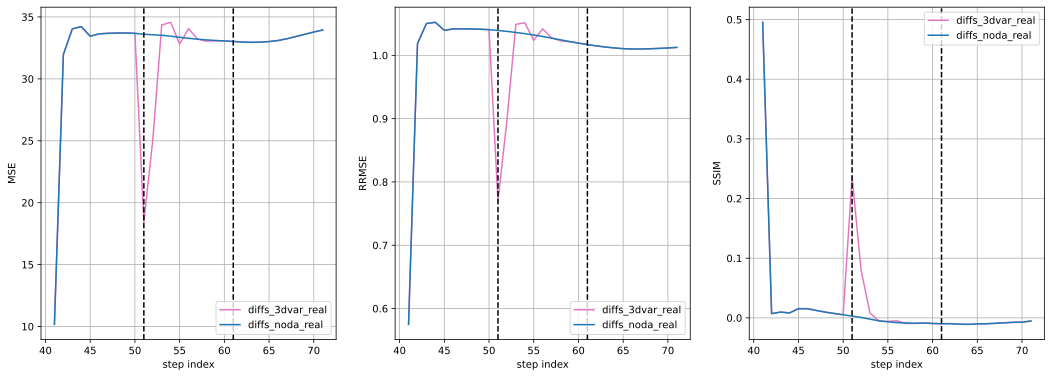

diffs_noda_real_mse[da_idxs[0]]=tensor(33.6089), diffs_noda_real_mse[da_idxs[1]]=tensor(33.0219)
diffs_da_real_mse[da_idxs[0]]=tensor(18.4577), diffs_da_real_mse[da_idxs[1]]=tensor(33.0212)
diffs_noda_real_rrmse[da_idxs[0]]=tensor(1.0394), diffs_noda_real_rrmse[da_idxs[1]]=tensor(1.0170)
diffs_da_real_rrmse[da_idxs[0]]=tensor(0.7702), diffs_da_real_rrmse[da_idxs[1]]=tensor(1.0170)
diffs_noda_real_ssim[da_idxs[0]]=np.float32(0.0028908749), diffs_noda_real_ssim[da_idxs[1]]=np.float32(-0.0098447455)
diffs_da_real_ssim[da_idxs[0]]=np.float32(0.23636976), diffs_da_real_ssim[da_idxs[1]]=np.float32(-0.009858512)


In [22]:
step_idxs = list(range(start_da_end_idxs[0] + 1, start_da_end_idxs[-1] + 2))

_, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].plot(step_idxs, diffs_da_real_mse, color="#e377c2", label="diffs_3dvar_real")
ax[0].plot(step_idxs, diffs_noda_real_mse, color="#1f77b4", label="diffs_noda_real")

ax[1].plot(step_idxs, diffs_da_real_rrmse, color="#e377c2", label="diffs_3dvar_real")
ax[1].plot(step_idxs, diffs_noda_real_rrmse, color="#1f77b4", label="diffs_noda_real")

ax[2].plot(step_idxs, diffs_da_real_ssim, color="#e377c2", label="diffs_3dvar_real")
ax[2].plot(step_idxs, diffs_noda_real_ssim, color="#1f77b4", label="diffs_noda_real")

for i, name in enumerate(["MSE", "RRMSE", "SSIM"]):
    ax[i].set_xlabel("step index")
    ax[i].set_ylabel(name)
    ax[i].grid(True)
    ax[i].legend()
    for x in time_obs:
        ax[i].axvline(x=x+1, color="k", linestyle="--")

plt.show()

da_idxs = [10, 20]
print(f"{diffs_noda_real_mse[da_idxs[0]]=}, {diffs_noda_real_mse[da_idxs[1]]=}")
print(f"{diffs_da_real_mse[da_idxs[0]]=}, {diffs_da_real_mse[da_idxs[1]]=}")
print(f"{diffs_noda_real_rrmse[da_idxs[0]]=}, {diffs_noda_real_rrmse[da_idxs[1]]=}")
print(f"{diffs_da_real_rrmse[da_idxs[0]]=}, {diffs_da_real_rrmse[da_idxs[1]]=}")
print(f"{diffs_noda_real_ssim[da_idxs[0]]=}, {diffs_noda_real_ssim[da_idxs[1]]=}")
print(f"{diffs_da_real_ssim[da_idxs[0]]=}, {diffs_da_real_ssim[da_idxs[1]]=}")

50
18438.18
13328.994
60
18411.71
18411.592


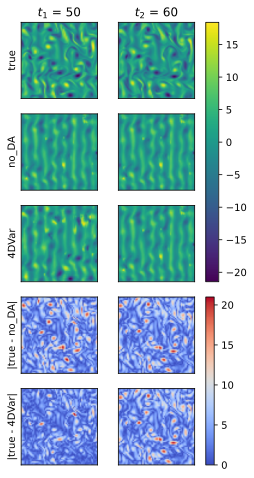

In [24]:
fig, ax = plt.subplots(5, len(da_idxs), figsize=(2 * len(da_idxs), 8), sharex=True)
for x in ax.flat:
    x.set_xticks([])
    x.set_yticks([])
    x.set_xticklabels([])
    x.set_yticklabels([])

setup_cmap = True
with torch.no_grad():
    for i, da_idx in enumerate(da_idxs):
        if i == 0:
            img_tensor = real_img[time_obs[i]+1, 0, ...]
        else:
            img_tensor = real_img[time_obs[i], 0, ...]
        print(time_obs[i])
        im1 = ax[0, i].imshow(torch.reshape(img_tensor, (64, 64)), cmap="viridis")
        if setup_cmap:
            # Create a ScalarMappable object with the colormap from images
            sm1 = plt.cm.ScalarMappable(cmap=im1.cmap, norm=im1.norm)
        no_da = forward_model.K_S_preimage(outs_no_4d_da[da_idx]).cpu()
        da = forward_model.K_S_preimage(outs_4d_da[da_idx]).cpu()

        de_no_da = denorm(no_da)
        de_da = denorm(da)

        image_noda = de_no_da[0, 0, ...]
        image_da = de_da[0, 0, ...]

        print(np.sum(np.abs(img_tensor.numpy() - image_noda.numpy())))
        print(np.sum(np.abs(img_tensor.numpy() - image_da.numpy())))

        ax[1, i].imshow(torch.reshape(image_noda, (64, 64)), cmap="viridis")
        ax[2, i].imshow(torch.reshape(image_da, (64, 64)), cmap="viridis")
        res = (img_tensor.reshape((64, 64)) - image_noda.reshape((64, 64))).abs()
        res = torch.where(res > 0.1, res, 0)
        im2 = ax[3, i].imshow(res, cmap="coolwarm")
        if setup_cmap:
            sm2 = plt.cm.ScalarMappable(cmap=im2.cmap, norm=im2.norm)
        res = (img_tensor.reshape((64, 64)) - image_da.reshape((64, 64))).abs()
        res = torch.where(res > 0.1, res, 0)
        ax[4, i].imshow(res, cmap="coolwarm")
        setup_cmap = False

# for i, title in enumerate([f"$t_1$ = {time_obs[0]}", f"$t_2$ = {time_obs[1]}", f"$t_3$ = {time_obs[2]}"]):
for i, title in enumerate([f"$t_1$ = {time_obs[0]}", f"$t_2$ = {time_obs[1]}"]):
    ax[0, i].set_title(title)
# ax[0].set_title("$t$")
for i, ylabel in enumerate(["true", "no_DA", "4DVar", "|true - no_DA|", "|true - 4DVar|"]):
    ax[i, 0].set_ylabel(ylabel)

# # Create a ScalarMappable object with the colormap from images
# sm1 = plt.cm.ScalarMappable(cmap=im1.cmap, norm=im1.norm)

# Remove the set_array to avoid warning
sm1.set_array([])

# Add a colorbar to the figure that uses the ScalarMappable
# fig.colorbar(sm1, ax=ax, orientation="vertical")

fig.colorbar(sm1, ax=ax[:-2, :], orientation="vertical")
sm2 = plt.cm.ScalarMappable(cmap=im2.cmap, norm=im2.norm)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[-2:, :], orientation="vertical")

plt.show()

In [25]:
no_da_image = []

for i in outs_no_4d_da:
    no_da = forward_model.K_S_preimage(i)

    de_no_da = denorm(no_da)

    no_da_image.append(de_no_da.detach().numpy())

print(len(no_da_image))
print(no_da_image[0].shape)

no_da_images = np.concatenate(no_da_image)
no_da_images.shape

31
(1, 1, 64, 64)


(31, 1, 64, 64)

In [30]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

def show_velocity_magnitude_animation(no_da_images):
    """
    Display animation of velocity magnitude from 2-channel 64x64 data in Jupyter Notebook.

    Parameters:
    - no_da_images: numpy array of shape [T, 2, 64, 64], where channel 0 is u, channel 1 is v
    """
    T, C, H, W = no_da_images.shape

    # Compute velocity magnitude
    velocity_magnitude = no_da_images[:, 0]

    vmin = velocity_magnitude.min()
    vmax = velocity_magnitude.max()

    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(velocity_magnitude[0], cmap='viridis', vmin=vmin, vmax=vmax)
    title = ax.set_title("Velocity Magnitude - Frame 0")
    ax.axis("off")
    fig.colorbar(im, ax=ax)

    def update(frame):
        im.set_array(velocity_magnitude[frame])
        title.set_text(f"Velocity Magnitude - Frame {frame}")
        return [im, title]

    ani = animation.FuncAnimation(fig, update, frames=T, interval=200, blit=True)
    plt.close(fig)
    return HTML(ani.to_jshtml())

In [31]:
show_velocity_magnitude_animation(no_da_images)

In [ ]:
eigvals = torch.linalg.eigvals(forward_model.C_forward)
spectral_radius = eigvals.abs().max()
print("Spectral radius of K_S:", spectral_radius.item())

Spectral radius of K_S: 0.9212825298309326
